<a href="https://colab.research.google.com/github/estevaosmith/Portifolio/blob/main/PROJETO_Segmentacao_de_clientes_com_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentação de Clientes

Para nossa segmentação de clientes, faremos uma análise **RFM**.

De acordo com [clevertap.com](https://clevertap.com/blog/rfm-analysis/), RFM significa **Recência**, **Frequência** e **Valor Monetário**, cada um correspondendo a uma característica chave do cliente. Essas métricas RFM são indicadores importantes do comportamento do cliente porque a frequência e o valor monetário afetam o valor vitalício do cliente, e a recência afeta a retenção, uma medida de engajamento.

<center><img width="60%" src="https://img.freepik.com/vetores-gratis/ilustracao-do-conceito-abstrato-de-segmentacao-de-audiencia_335657-1854.jpg?t=st=1720456822~exp=1720460422~hmac=3ec780c74e5d4baa5598f6c59610e13828d670a2f4029bdc52fef88724504236&w=740"></center>

### Por que isso é importante? O que podemos obter com isso?

* Quem são seus melhores clientes?
* Quais dos seus clientes podem contribuir para a sua taxa de cancelamento?
* Quem tem o potencial de se tornar um cliente valioso?
* Quais dos seus clientes podem ser retidos?
* Quais dos seus clientes têm mais probabilidade de responder às campanhas de engajamento?

Essas são perguntas-chave que podemos responder com esta análise. Vou utilizar a biblioteca Pycaret para construir o modelo de Cluster.

In [ ]:
!pip install pycaret
import pycaret
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import datetime as dt
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
import scipy.stats as scs

import warnings
warnings.filterwarnings("ignore")
sns.set_style()
%matplotlib inline

# Import statements required for Plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [5]:
# Importando o dataset
path = ('/content/data_clean.csv')
df_clean = pd.read_csv(path, encoding='latin-1')

df_clean.index = pd.to_datetime(df_clean['InvoiceDate'], infer_datetime_format=True)

df_clean.drop('InvoiceDate', axis=1, inplace=True)


df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,AmountSpent,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,Weekend
InvoiceDate,,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,white hanging heart t-light holder,6,2.55,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,536365,71053,white metal lantern,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850,United Kingdom,22.00,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,536365,84029G,knitted union flag hot water bottle,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,536365,84029E,red woolly hottie white heart.,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0


## Recência

Primeiro, vamos entender nossos dados e ver qual é o último dia do conjunto de dados. Isso é importante para calcularmos as métricas necessárias para nossa Análise RFM.

In [6]:
# Ultima data do dataset
df_clean.index.max()

Timestamp('2011-01-09 14:36:00')

In [7]:
# Calculando as diferencas
now = dt.date(2011,12,9)

In [8]:
# Agrupando os clientes pela ultima data de compra

recency_df = df_clean.groupby(['CustomerID'],as_index=False)['Date'].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df['LastPurchaseDate'] = pd.DatetimeIndex(recency_df.LastPurchaseDate).date
recency_df.head()

,CustomerID,LastPurchaseDate
0,12347,2010-12-07
1,12348,2010-12-16
2,12370,2010-12-17
3,12377,2010-12-20
4,12383,2010-12-22


In [9]:
# Calculando a frequencia que os clientes compram

recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x : (now - x).days)


recency_df.drop(columns=['LastPurchaseDate'],inplace=True)

recency_df.head()

,CustomerID,Recency
0,12347,367
1,12348,358
2,12370,357
3,12377,354
4,12383,352


Great! We now have the time in days since the last purchase made by our customers.

## Frequência

A frequência é calculada pelo número de compras que um consumidor fez ao longo do tempo.

Vamos ver como isso se apresenta em nossos dados.

In [10]:
# Calculando frequencia
frequency_df = df_clean.copy()
frequency_df.drop_duplicates(subset=['CustomerID','InvoiceNo'], keep="first", inplace=True)
frequency_df = frequency_df.groupby('CustomerID',as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12347,1
1,12348,1
2,12370,2
3,12377,1
4,12383,1


## Valor Monetário

O último aspecto a ser analisado é a parte monetária. Ou seja, quanto dinheiro está sendo gasto pelos clientes.

In [11]:
# Somando o valor que os clientes gastaram

monetary_df=df_clean.groupby('CustomerID',as_index=False)['AmountSpent'].sum()
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12347,711.79
1,12348,892.80
2,12370,1868.02
3,12377,1001.52
4,12383,600.72


In [12]:
# Juntando as 3 metricas em um unico dataset
rf = recency_df.merge(frequency_df,left_on='CustomerID',right_on='CustomerID')

rfm = rf.merge(monetary_df,left_on='CustomerID',right_on='CustomerID')

rfm.set_index('CustomerID',inplace=True)

rfm.to_csv('rfm.csv', index=False)


rfm.head(10)

,Recency,Frequency,Monetary
CustomerID,,,
12347,367,1,711.79
12348,358,1,892.80
12370,357,2,1868.02
12377,354,1,1001.52
12383,352,1,600.72
12386,337,2,401.90
12395,357,2,679.92
12413,337,1,479.25
12415,337,1,7011.38


## Segmentação e Avaliação

Para fazer uma segmentação adequada de nossos clientes, usaremos **K-Means Clustering** para criar grupos de clientes, que nomearemos como:

* **Ouro** - Frequentes e geram alto volume de receita.
* **Prata** - Frequentes, mas geram menos receita.
* **Bronze** - Menos frequentes, baixa receita.

In [13]:
# Importando o pycaret
from pycaret.clustering import *

# Criando o setup
s = setup(rfm, session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(972, 3)"
2,Transformed data shape,"(972, 3)"
3,Numeric features,3
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


In [15]:
#Treinando o modelo e associando os resultados em um novo dataset
kmeans = create_model('kmeans',num_clusters = 3)
kmean_results = assign_model(kmeans)
kmean_results.head(10)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8818,2132.1262,0.3945,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347,367,1,711.789978,Cluster 0
12348,358,1,892.799988,Cluster 0
12370,357,2,1868.020020,Cluster 0
12377,354,1,1001.520020,Cluster 0
12383,352,1,600.719971,Cluster 0
12386,337,2,401.899994,Cluster 0
12395,357,2,679.919983,Cluster 0
12413,337,1,479.250000,Cluster 0
12415,337,1,7011.379883,Cluster 1


#### Método do Cotovelo

Para o K-Means, precisamos definir um número de clusters para dividir nossos dados. Como essa é, inicialmente, uma tarefa completamente arbitrária, devemos buscar opções para torná-la o mais precisa possível.

Um dos métodos mais populares para isso é o **Método do Cotovelo**. Basicamente, calculamos diferentes cenários para diferentes números de clusters e depois os plotamos em um gráfico de linha.

O número que procuramos é a posição onde a linha começa a achatar, fazendo com que pareça um cotovelo no gráfico. Apesar do pycaret dizer que 4 seria o numero ideal de clusuter, escolhi por 3 para melhor compreensao do negocio.

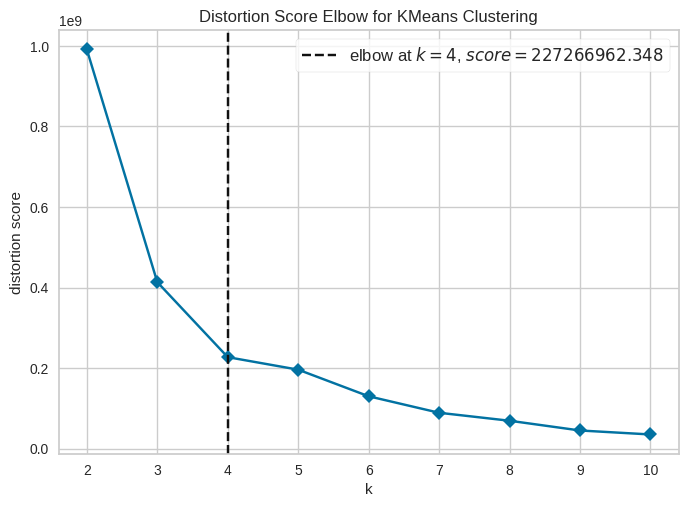

In [17]:
plot_model(kmeans, plot = 'elbow')

### Recência

* O Cluster 0 tem uma **alta taxa de recência**, o que significa que é o cluster com o maior tempo desde a última compra.
* Os Clusters 1 e 2 têm uma **baixa taxa de recência**, o que é bom. Eles podem ser nossos clientes Ouro e Prata.


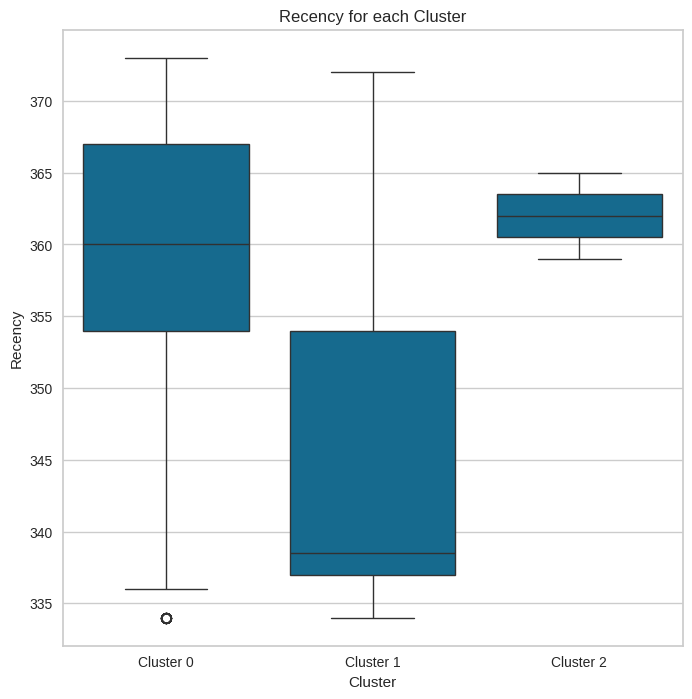

In [29]:
# Analisando a recencia
fig, ax = plt.subplots(figsize=(8,8))
plt.title('Recencia para cada cluster')
sns.boxplot(x='Cluster', y='Recency', data=kmean_results)
plt.show()

### Frequency

* Cluster 0 has a **low frequency rate**, which means consumers in this cluster are not very frequent.
* Clusters 1 and 2 have **high frequency rates**, which puts them even further in the race for Gold.

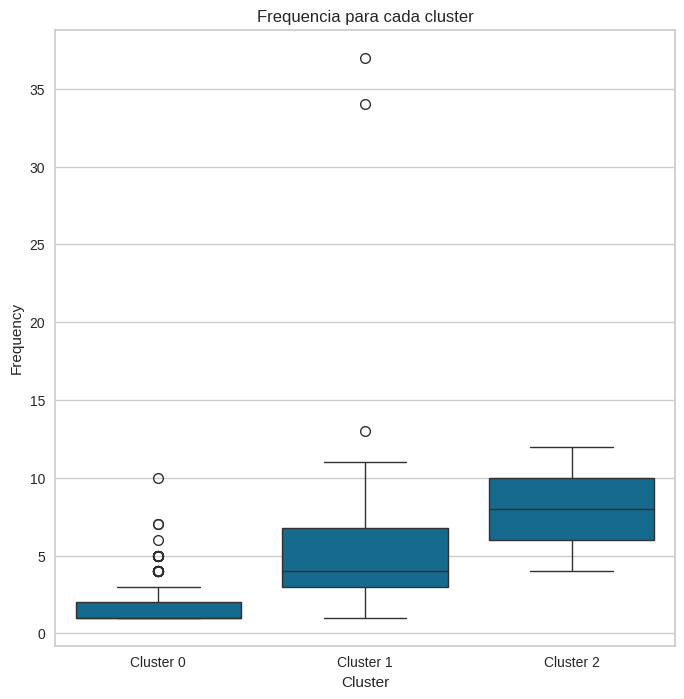

In [32]:
# Analisando a frequencia
fig, ax = plt.subplots(figsize=(8,8))
plt.title('Frequencia para cada cluster')
sns.boxplot(x= "Cluster", y = "Frequency" ,data = kmean_results);

### Valor Monetário

* O Cluster 0 tem uma **taxa monetária baixa**, indicando que é onde estão nossos clientes **Bronze**.
* O Cluster 1 tem uma **taxa monetária média**, o que o torna o cluster para nossos clientes **Prata**.
* O Cluster 2 tem a **taxa monetária mais alta**, fazendo dele o cluster para nossos clientes **Ouro**.

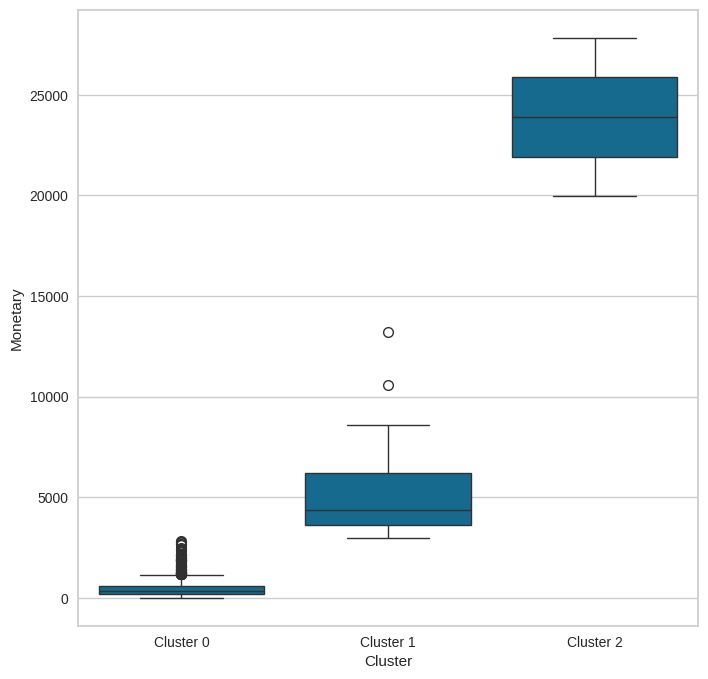

In [37]:
# Analisando as metricas monetarias
fig, ax = plt.subplots(figsize=(8,8))
sns.boxplot(x = "Cluster", y = "Monetary", data = kmean_results);

### Conclusões

Como vimos anteriormente, descobrimos que:
<center><img width="50%" src="https://img.freepik.com/vetores-gratis/ilustracao-do-conceito-de-segmentacao_114360-7359.jpg?t=st=1720459204~exp=1720462804~hmac=a5b3d43fb519b9d8b70948fcfbca10be9d74dfae65634b78e1093560872fe224&w=740"></center>

* Clientes **Ouro** estão no Cluster 2
* Clientes **Prata** estão no Cluster 1
* Clientes **Bronze** estão no Cluster 0